# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для компании «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В нашем распоряжении 3 файла с сырыми данными.

- gold_recovery_full_new.csv. - содержит весь объем данных 
- gold_recovery_train_new.csv. и gold_recovery_test_new.csv. - это условная разбивка полного датасета на тренировочную и тесвую выборки

Столбцы представленые в датасетах - это различные параметры с 4-х последовательных этапов процесса извлечения золота из руды:

* rougher — флотация (после прохождения данного этапа мы получаем черновой концентрат)

* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики ( на данном этапе мы получаем - финальный концентрат)

Наименование признаков в столбцах должно быть такое:

[этап].[тип_параметра].[название_параметра]

Возможные значения для блока [этап]:

- rougher — флотация
- primary_cleaner — первичная очистка 
- secondary_cleaner — вторичная очистка 
- final — финальные характеристики 

Возможные значения для блока [тип_параметра]:

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики


Условные обозначения для блока [название_параметра]:

- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия). 

- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

## Подготовка данных

In [1]:
# импортируем библиотеки  

import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from scipy.stats import kstest
#!pip install pandas-profiling[notebook]
#from pandas_profiling import ProfileReport

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import mean_squared_error
#import scipy.stats as st
#from sklearn.metrics import confusion_matrix


pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

1.1. Откроем файлы и изучим их.

In [2]:
# загрузим датасеты
# Данные индексируются датой и временем получения информации (признак date).
try:
    gold_train=pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date') # обучающая выборка;
    gold_test=pd.read_csv('datasets/gold_recovery_test_new.csv', index_col='date') # тестовая выборка;
    gold_full=pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date') # исходные данные.
except:
    gold_train=pd.read_csv('https://code.s3.yandex.net//datasets/gold_recovery_train_new.csv', index_col='date')
    gold_test=pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date')
    gold_full=pd.read_csv('https://code.s3.yandex.net//datasets/gold_recovery_full_new.csv', index_col='date')

# переменная со списком всех датасетов
all_data = [gold_full, gold_train, gold_test]

Функции:

In [3]:
def description(i):
# фунция выводит первые 3 строки датасета
# общую информацию о столбцах и типах данных в них
# основные описательные статистики
# колличество полных дубликатов строк
# коллисечтво пропусков
    display(i.head(3))
    print()
    display(i.info())
    print()
    display(i.describe())
    print()
    print('Полных дубликатов:', i.duplicated().sum())  
    print()
    return pd.DataFrame(round(i.isna().mean()*100,2)).style.background_gradient('coolwarm')

In [4]:
def search (word, where):
# функция для поиска и вывода строк содержащих заданное слово
# на вход подается: "искомое_слово" , место_поиска    
    for i in (where):
        if word in i:
            print(i)

Приступим к изучению данных.

In [5]:
description(gold_full)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.


<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                            

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438


Полных дубликатов: 0



,0
final.output.concentrate_ag,0.010000
final.output.concentrate_pb,0.010000
final.output.concentrate_sol,1.090000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.010000
final.output.tail_pb,0.520000
final.output.tail_sol,0.030000
final.output.tail_au,0.000000
primary_cleaner.input.sulfate,0.120000


Датасет full содержит 86 столбцов и 19440 строк. Для ряда столбцов является нормальным наличие отрицательных значений. Такими столбцами являются признаки технологического процесса, - уровень жидкости и давление воздуха. В нескольких столбцах есть пропуски, наибольшее колличество в secondary_cleaner.output.tail_sol.

Дополнительно видно, что у ряда признаков имеются нулевые значения, необходимо детальнее рассмотреть их значимость.

In [6]:
description(gold_train)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.


<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                            

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148


Полных дубликатов: 0



,0
final.output.concentrate_ag,0.010000
final.output.concentrate_pb,0.010000
final.output.concentrate_sol,1.490000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.710000
final.output.tail_sol,0.040000
final.output.tail_au,0.000000
primary_cleaner.input.sulfate,0.140000


Датасет gold_train содержит  86 строк и 14150 строк. Данные в подходящам для дальнейшего исследрвания формате. Ряд колонок содержит пропуски. Дубликотов не выявленно.

In [7]:
description(gold_test)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559



<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-nul

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20


Полных дубликатов: 0



,0
primary_cleaner.input.sulfate,0.080000
primary_cleaner.input.depressant,0.090000
primary_cleaner.input.feed_size,0.000000
primary_cleaner.input.xanthate,0.080000
primary_cleaner.state.floatbank8_a_air,0.000000
primary_cleaner.state.floatbank8_a_level,0.000000
primary_cleaner.state.floatbank8_b_air,0.000000
primary_cleaner.state.floatbank8_b_level,0.000000
primary_cleaner.state.floatbank8_c_air,0.000000
primary_cleaner.state.floatbank8_c_level,0.000000


Датасет gold_test содержит 52 столбца и 5290 строк. Видим, что в тестовой выборке отсутствует часть столбцов. 

1.2. Проверим, что эффективность обогащения рассчитана правильно.

Вычислим её на обучающей выборке для признака rougher.output.recovery.

recovery = ((C(F-T))/(FC-T))*100%, где:

- С - доля золота в концентрате после фильтрации/очитски (rougher.output.concentrate_au)
- F - доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au)
- T - доля золота в отвальных хвостах после фильтрации/очистки (rougher.output.tail_au)

In [8]:
c = gold_train['rougher.output.concentrate_au']
f = gold_train['rougher.input.feed_au']
t = gold_train['rougher.output.tail_au']
recovery = ((c*(f-t))/(f*(c-t))) * 100

print('Средняя расчетная эф-ть обогащения на обучающей выборке:',recovery.mean())
print('Средняя эф-ть обогацения в признаке rougher.output.recovery:',gold_train['rougher.output.recovery'].mean())

Средняя расчетная эф-ть обогащения на обучающей выборке: 82.70450164550293
Средняя эф-ть обогацения в признаке rougher.output.recovery: 82.70450164550293


Значения совпадают. Можно предположить, что эффективнсть рассчитанна верно.

 Найдем MAE между полученными значениями (recovery) и значением признака (rougher.output.recovery).

In [9]:
print('MAE:', mean_absolute_error(gold_train['rougher.output.recovery'], recovery))

MAE: 9.73512347450521e-15


Значение MAE очень маленькое, это подтверждает наше предположение о том, что эффективность обогащения рассчитана верно.

1.3. Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [10]:
different_columns = list(set(gold_train.columns) - set(gold_test.columns))
different_columns

['final.output.concentrate_sol',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'final.output.recovery',
 'rougher.output.tail_sol',
 'rougher.output.recovery',
 'rougher.output.concentrate_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_sol',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'final.output.tail_sol',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.tail_pb',
 'rougher.output.tail_pb',
 'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'final.output.concentrate_pb',
 'rougher.calculation.au_pb_ratio',
 'final.output.tail_ag',
 'primary_cleaner.output.conc

In [11]:
print('Обучающая выборка сожержит {} колонки не вошедшие в тестовую'.format(len(different_columns)))

Обучающая выборка сожержит 34 колонки не вошедшие в тестовую


In [12]:
#Наименование признаков:
#[этап].[тип_параметра].[название_параметра]
stage = collections.Counter()
parameter_type = collections.Counter()
parameter_name = collections.Counter()

for i in different_columns:
    words = list(map(str,i.split(".")))
    stage[words[0]] += 1
    parameter_type[words[1]] += 1
    parameter_name[words[2]] += 1
    
print('[этап]:',stage)
print('\n[тип_параметра]:',parameter_type)
print('\n[название_параметра]:',parameter_name)

[этап]: Counter({'rougher': 13, 'final': 9, 'primary_cleaner': 8, 'secondary_cleaner': 4})

[тип_параметра]: Counter({'output': 30, 'calculation': 4})

[название_параметра]: Counter({'tail_au': 4, 'tail_ag': 4, 'tail_sol': 4, 'tail_pb': 4, 'concentrate_sol': 3, 'concentrate_au': 3, 'concentrate_ag': 3, 'concentrate_pb': 3, 'recovery': 2, 'floatbank11_sulfate_to_au_feed': 1, 'sulfate_to_au_concentrate': 1, 'floatbank10_sulfate_to_au_feed': 1, 'au_pb_ratio': 1})


Видим, что в тестовой выборке отсутствуют:

- 9 столбцов, характеризующие финальные характеристики продукта (final.output);
- 8 столбцов, характеризующие продукт на этапе первичной очистки (primary_cleaner.output); 
- 4 столбца, характеризующих расчетные характеристики на этапе флотации (rougher.calculation); 
- 9 столбцов, характеризующих продукт посте этапа флотации (rougher.output); 
- 4 столбца, характеризующие продукт на этапе вторичной очистки (secondary_cleaner.output). 

- 30 - содержат тип параметра output (параметр продукта)
- 4 - содержат тип параметра calculation (расчетные характеистики)


Также при изучении датасетов видно, что признаки обладают различным масштабом, поэтому потребуется применить масштабирование.

Отметим, что при обучении модели лишние признаки не должны быть включены в обучающую выборку. Но они могут понадобится для исследовательского анализа данных.

1.4.Проведем предобработку данных.

Зная, что данные индексируются датой и временем получения информации и соседние по времени параметры часто похожи, заполним пропуски соответствующими значениями в предъидущем ряду методом ffil.


In [13]:
#заполняем пропуски
for i in all_data:
    i.ffill(axis='rows', inplace=True)

In [14]:
#Проверим данные на мультиколлениарность.
corr_table = gold_full.corr().unstack().sort_values().drop_duplicates()
#display(corr_table)
print(corr_table)
#corr_table[(corr_table > 0.7) | (corr_table < -0.7)].count()

rougher.state.floatbank10_a_level  secondary_cleaner.output.tail_sol   -0.630015
rougher.state.floatbank10_d_air    primary_cleaner.output.tail_pb      -0.591734
rougher.state.floatbank10_c_air    primary_cleaner.output.tail_pb      -0.586921
primary_cleaner.output.tail_pb     rougher.state.floatbank10_b_air     -0.553605
rougher.state.floatbank10_c_air    primary_cleaner.output.tail_ag      -0.517098
                                                                          ...   
rougher.state.floatbank10_d_level  rougher.state.floatbank10_b_level    0.971205
rougher.state.floatbank10_c_level  rougher.state.floatbank10_d_level    0.980911
rougher.state.floatbank10_f_level  rougher.state.floatbank10_e_level    0.980917
rougher.state.floatbank10_b_level  rougher.state.floatbank10_c_level    0.987836
final.output.concentrate_ag        final.output.concentrate_ag          1.000000
Length: 3656, dtype: float64


In [15]:
#Еще раз проверим на наличие явных дубликатов
for i in all_data:
    print(i.duplicated().sum())

0
0
0


In [16]:
print('Размер тестовой выборки:{}\nРазмер тренировочной выборки:{}'.format(gold_test.shape, gold_train.shape))

Размер тестовой выборки:(5290, 52)
Размер тренировочной выборки:(14149, 86)


В данном разделе открыты файлы и изучены основные данные.

У некоторых признаков видно значимое число значений в области нуля. Вероятно это выбросы. В дальнейшем анализе нужно обратить на них внимание.

Проверен расчёт эффективности обогащения. Вычислено значение MAE между данными и расчётными значениями эффективности. Полученные значения МАЕ близки к 0. Это означаем, что эффективность обогащения рассчитана правильно. 

Рассмотренны поля недоступные в тестовой выборке, где отсутствуют целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. Это концентрации элементов после основных операций. Предположительно эти даные, возможно получить только после реальных измерений. Поэтому для постороения прогноза  в файле test этих данных быть не должно .

Дубликаты не выявленны. Пропуски заполненны соседними значениями.

## Анализ данных

2.1.Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
Рассматривать будем данные из полного датасета gold_full

Металлы:
- Au - золото
- Ag - серебро
- Pb - свинец
- Sol - примеси

Этапы:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

In [17]:
search ('output.concentrate', gold_full)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au


In [18]:
search ('input.feed', gold_full)

primary_cleaner.input.feed_size
rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.feed_au


In [19]:
# золото
au_concentrate = gold_full[['rougher.input.feed_au',
                            'rougher.output.concentrate_au',
                            'primary_cleaner.output.concentrate_au',
                            'final.output.concentrate_au']]
#серебро
ag_concentrate = gold_full[['rougher.input.feed_ag',
                            'rougher.output.concentrate_ag',
                     'primary_cleaner.output.concentrate_ag',
                            'final.output.concentrate_ag']]
# свинец
pb_concentrate = gold_full[['rougher.input.feed_pb',
                            'rougher.output.concentrate_pb',
                     'primary_cleaner.output.concentrate_pb',
                     'final.output.concentrate_pb']]

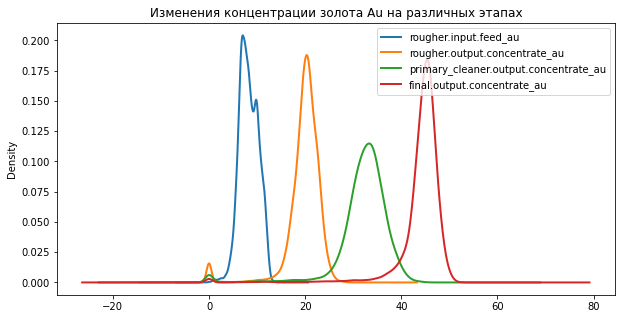

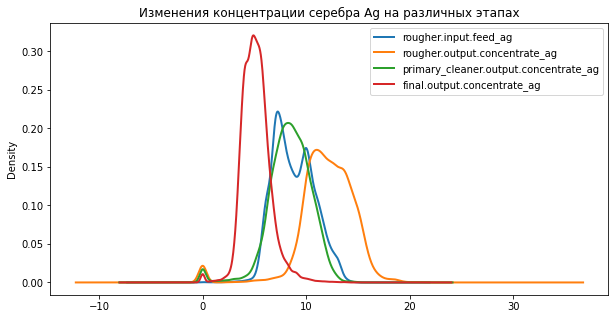

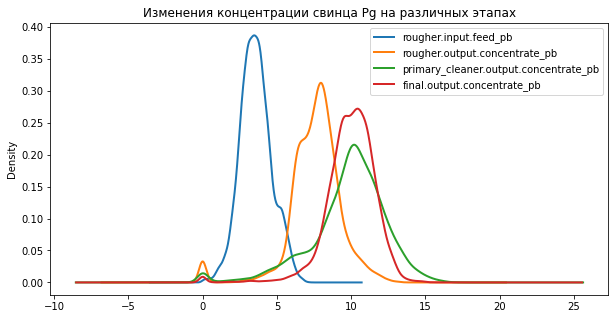

In [20]:
( au_concentrate.plot( kind ='kde',figsize=(10, 5), linewidth = 2)
                .set_title('Изменения концентрации золота Au на различных этапах')
);
( ag_concentrate.plot(kind ='kde',figsize=(10, 5), linewidth = 2)
                .set_title('Изменения концентрации серебра Ag на различных этапах')
);
( pb_concentrate.plot(kind ='kde',figsize=(10, 5), linewidth = 2)
                .set_title('Изменения концентрации свинца Pg на различных этапах')
);

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

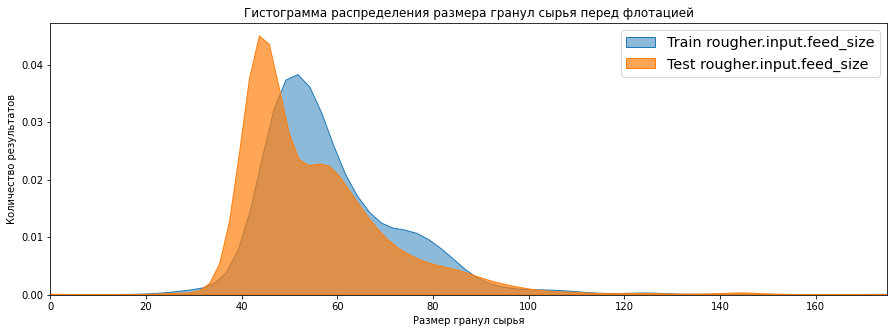

In [22]:
# Перед флотацией
plt.figure(figsize=[15,5])
sns.kdeplot(gold_train['rougher.input.feed_size'],label = 'Train rougher.input.feed_size', alpha=.5, shade = True)
sns.kdeplot(gold_test['rougher.input.feed_size'],label = 'Test rougher.input.feed_size', alpha=.7, shade = True)
plt.xlim([0,175])
plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма распределения размера гранул сырья перед флотацией")
plt.show()

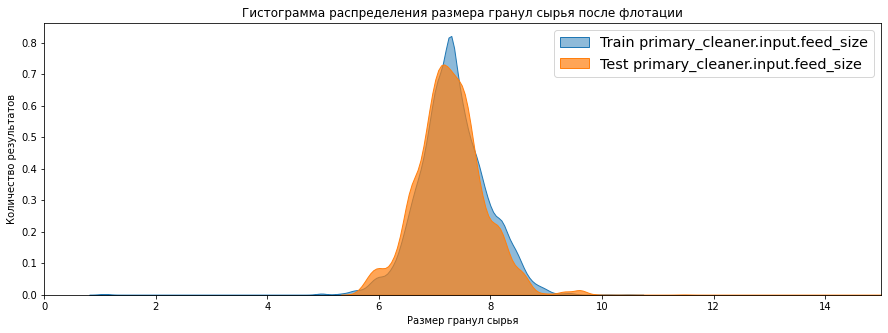

In [23]:
# После флотации
plt.figure(figsize=[15,5])
sns.kdeplot(gold_train['primary_cleaner.input.feed_size'],label = 'Train primary_cleaner.input.feed_size',\
            alpha=.5, shade = True)
sns.kdeplot(gold_test['primary_cleaner.input.feed_size'],label = 'Test primary_cleaner.input.feed_size',\
            alpha=.7, shade = True)
plt.xlim([0,15])
plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма распределения размера гранул сырья после флотации")
plt.show()

In [24]:
# выполним статистический тест Колмогорова-Смирнова
stat, p_value = kstest(gold_train['primary_cleaner.input.feed_size'],gold_test['primary_cleaner.input.feed_size'])
print(f" Kolmogorov-Smirnov Test: statistic={stat:.3f}, p-value={p_value:.3f}")

 Kolmogorov-Smirnov Test: statistic=0.059, p-value=0.000


2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [25]:

rougher_input_feed_sum_full = (gold_full['rougher.input.feed_ag']+
                          gold_full['rougher.input.feed_pb']+
                          gold_full['rougher.input.feed_sol']+
                          gold_full['rougher.input.feed_au'])

rougher_output_concentrate_sum_full = (gold_full['rougher.output.concentrate_au'] + 
                                        gold_full['rougher.output.concentrate_ag'] + 
                                        gold_full['rougher.output.concentrate_pb'] +
                                        gold_full['rougher.output.concentrate_sol'])
primary_cleaner_output_concentrate_sum_full = (gold_full['primary_cleaner.output.concentrate_au'] + 
                                                gold_full['primary_cleaner.output.concentrate_ag'] + 
                                                gold_full['primary_cleaner.output.concentrate_pb'] +
                                                gold_full['primary_cleaner.output.concentrate_sol'])
final_output_concentrate_sum_full = (gold_full['final.output.concentrate_au'] + 
                                      gold_full['final.output.concentrate_ag'] + 
                                      gold_full['final.output.concentrate_pb'] +
                                      gold_full['final.output.concentrate_sol'])


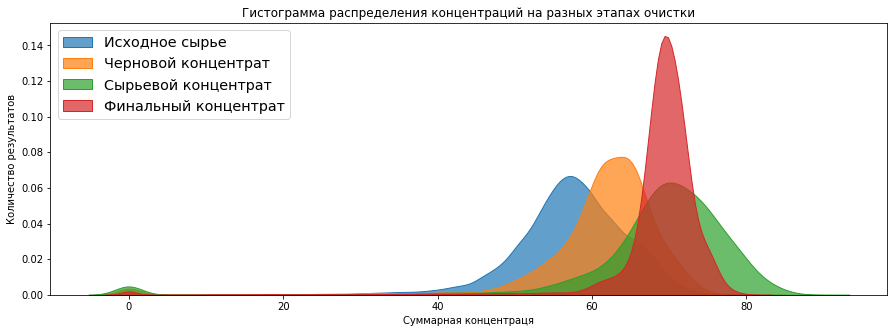

In [27]:
plt.figure(figsize=[15,5])

#plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'Черновой концентрат', alpha=.4)
#plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'Сырьевой концентрат', alpha=.4)
#plt.hist(final_output_concentrate_sum_train, bins=100, label = 'Финальный концентрат', alpha=.4)

sns.kdeplot(rougher_input_feed_sum_full,label = 'Исходное сырье',alpha=.7, shade = True)
sns.kdeplot(primary_cleaner_output_concentrate_sum_full,label = 'Черновой концентрат',alpha=.7, shade = True)
sns.kdeplot(rougher_output_concentrate_sum_full,label = 'Сырьевой концентрат',alpha=.7, shade = True)
sns.kdeplot(final_output_concentrate_sum_full,label = 'Финальный концентрат',alpha=.7, shade = True)

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

Удалим 0 выбросы

In [28]:
gold_train = gold_train[(gold_train['rougher.output.concentrate_au'] != 0) &\
                        (gold_train['rougher.output.concentrate_ag'] != 0) &\
                        (gold_train['rougher.output.concentrate_pb'] != 0) &\
                        (gold_train['rougher.output.concentrate_sol'] != 0)]
gold_train = gold_train[(gold_train['final.output.concentrate_au'] != 0) &\
                        (gold_train['final.output.concentrate_ag'] != 0) &\
                        (gold_train['final.output.concentrate_pb'] != 0) &\
                        (gold_train['final.output.concentrate_sol'] != 0)]

gold_full = gold_full[(gold_full['rougher.output.concentrate_au'] != 0) &\
                      (gold_full['rougher.output.concentrate_ag'] != 0) &\
                      (gold_full['rougher.output.concentrate_pb'] != 0) &\
                      (gold_full['rougher.output.concentrate_sol'] != 0)]
gold_full = gold_full[(gold_full['final.output.concentrate_au'] != 0) &\
                      (gold_full['final.output.concentrate_ag'] != 0) &\
                      (gold_full['final.output.concentrate_pb'] != 0) &\
                      (gold_full['final.output.concentrate_sol'] != 0)]

In [29]:
#создадим датасет для целевых признаков, недостающих в тестовой выборке
df_target = gold_full[['rougher.output.recovery', 'final.output.recovery']]
#добавим эти признаки в тестовую выборку из полной
gold_test = gold_test.merge(df_target, how = 'left', on = 'date')
#удалим из тренировочной выборки те признаки, которых нет в тестовой
gold_train = gold_train.drop(set(gold_train.columns)-set(gold_test.columns), axis=1)
# список признаков для обучения модели
features_columns = list(gold_test.columns)[1:-2]
# список целевых признаков
target_columns = list(reversed(list(gold_test.columns)[-2:]))
target_columns

['final.output.recovery', 'rougher.output.recovery']

In [30]:
#извлекаем матрицу признаков
features_train = gold_train[features_columns]
features_test = gold_test[features_columns]
# извлекаем целевой признак

target_final_train = gold_train['final.output.recovery']
target_rougher_train = gold_train['rougher.output.recovery']

target_final_test = gold_test['final.output.recovery']
target_rougher_test = gold_test['rougher.output.recovery']

# оценим размеры
for _ in [features_train,features_test, target_final_train, target_rougher_train,\
          target_final_test,target_rougher_test]:
    print(_.shape)

(13792, 51)
(5290, 51)
(13792,)
(13792,)
(5290,)
(5290,)


Концентрация золота Au показывает 2 пика, на этапах флотации и финальном этапе.

Концентрация серебра Ag показывает постепенный рост от этапа к этапу.

Концентрация свинца Pb показываем максимальные показатели на этапе флотации, затем происходит постепенное падение.

На всех графиках концентрации сырья видны значения равные нулю. Судя по распределению, это выбросы. Было принято решение об их удалении.

Построены графики распределения плотности вероятности значений размеров гранул на входе в этапы флотации и финальной очистки выборок train и test. Распределения очень похожи, что позволяет предположить однородность данных размеров сырья в выборках train и test.

Исследованна суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
Суммарная концентрация колеблеца в диапазоне от 40 до 90.

Для проверки качества оценки модели поля 'rougher.output.recovery', 'final.output.recovery' добавлены в тестовый файл gold_test для формирования выборок target_rougher_test и target_final_test.

## Модель

3.1. Напишим функцию для вычисления итоговой sMAPE.


In [31]:
#функция для вычисления sMAPE:
def sMAPE (target, predict):
    smape = np.mean(abs(target - predict) / ((abs(target) + abs(predict)) / 2)) * 100
    return smape

In [32]:
# функция для вычисления итогового sMAPE:
def all_sMAPE (rougher,final):
    return abs(0.25*rougher + 0.75*final)

In [33]:
#Стандартизируем численные признаки
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [34]:
# модели
model_rf =  RandomForestRegressor()
model_dt = DecisionTreeRegressor()
model_lr = LinearRegression()

In [35]:
# зададим параметры для моделей
score = make_scorer(sMAPE, greater_is_better = False) 
state = RandomState(123)
parameters_rf = {'n_estimators':[x for x in range(1,8)],
                 'max_depth':[x for x in range(2,12,3)],
                'random_state':[123]}
parameters_dt = {'max_depth':[x for x in range(2,12,3)],
                'min_samples_leaf':[x for x in range(2,12,3)],
                'random_state':[123]}
parameters_lr = {'normalize': [False]}

3.2. Обучим разные модели и оцените их качество кросс-валидацией. Выберим лучшую модель и проверим её на тестовой выборке.

In [ ]:
%%time
# перебор гипперпараметров и обучение модели
grid_rf = GridSearchCV(model_rf, parameters_rf, cv=5,scoring =score ) #RandomForestRegressor
grid_rf_rougher = grid_rf.fit(features_train, target_rougher_train)
grid_rf_final = grid_rf.fit(features_train, target_final_train)

In [ ]:
%%time
# перебор гипперпараметров и обучение модели
grid_dt = GridSearchCV(model_dt, parameters_dt, cv=5,scoring =score ) #DecisionTreeRegressor
grid_dt_rougher = grid_dt.fit(features_train, target_rougher_train)
grid_dt_final = grid_dt.fit(features_train, target_final_train)

In [ ]:
%%time
# перебор гипперпараметров и обучение модели
grid_lr = GridSearchCV(model_lr, parameters_lr, cv=5,scoring =score ) #LinearRegression
grid_lr_rougher = grid_lr.fit(features_train, target_rougher_train)
grid_lr_final = grid_lr.fit(features_train, target_final_train)

In [ ]:
#определяю лучшую из моделей для 2 целевых признаков: 
best_score_grid_rf_rougher = grid_rf_rougher.best_score_
best_score_grid_rf_final = grid_rf_final.best_score_

best_score_grid_dt_rougher = grid_dt_rougher.best_score_
best_score_grid_dt_final = grid_dt_final.best_score_

best_score_grid_lr_rougher = grid_lr_rougher.best_score_
best_score_grid_lr_final = grid_lr_final.best_score_

print('RandomForestRegressor',(all_sMAPE(best_score_grid_rf_rougher, best_score_grid_rf_final)))
print()
print('DecisionTreeRegressor',(all_sMAPE(best_score_grid_dt_rougher, best_score_grid_dt_final)))
print()
print('LinearRegression ',(all_sMAPE(best_score_grid_lr_rougher, best_score_grid_lr_final)))

Лучший показатель sMAPE у модели RandomForestRegressor. Подберем для нее лучшие парраметры.

In [ ]:
%%time
print('Для модели RandomForestRegressor лучший результат на этапе флотации rougher:',grid_rf_rougher.best_params_)
print('Для модели RandomForestRegressor лучший результат на финальном этапе final:', grid_rf_final.best_params_)

In [ ]:
#%%time
#print('Для модели DecisionTreeRegressor лучший результат на этапе флотации rougher:',grid_dt_rougher.best_params_)
#print('Для модели DecisionTreeRegressor лучший результат на финальном этапе final:', grid_dt_final.best_params_)

In [ ]:
#%%time
#print('Для модели LinearRegression лучший результат на этапе флотации rougher:',grid_lr_rougher.best_params_)
#print('Для модели LinearRegression лучший результат на финальном этапе final:', grid_lr_final.best_params_)

In [57]:
#%%time
# сделаем кросс-валидацию методом cross_val_score для  RandomForestRegressor 
#rougher_rf = cross_val_score(model_rf, features_train, target_rougher_train, scoring=score, cv=5)
#final_rf =  cross_val_score(model_rf, features_train, target_final_train, scoring=score, cv=5)
#print('Итоговое sMape для RandomForestRegressor:', all_sMAPE(rougher_rf, final_rf).mean())

In [58]:
#%%time
# сделаем кросс-валидацию методом cross_val_score для  DecisionTreeRegressor 
#rougher_dt = cross_val_score(model_dt, features_train, target_rougher_train, scoring=score, cv=5)
#final_dt =  cross_val_score(model_dt, features_train, target_final_train, scoring=score, cv=5)
#print('Итоговое sMape для DecisionTreeRegressor:',all_sMAPE(rougher_dt, final_dt).mean())

In [59]:
#%%time
# сделаем кросс-валидацию методом cross_val_score для линейной регрессии 
#rougher_lr = cross_val_score(model_lr, features_train, target_rougher_train, scoring=score, cv=5)
#final_lr =  cross_val_score(model_lr, features_train, target_final_train, scoring=score, cv=5)
#print('Итоговое sMape для линейной регрессии:', all_sMAPE(rougher_lr, final_lr).mean())

Проверим на тестовой выборке модель показавшую лучший результат sMape с лучшими гипперпараметрами.
Ей стала RandomForestRegressor с параметрами:

In [ ]:
%%time
model_rf = RandomForestRegressor(max_depth = 5, n_estimators = 7, random_state = state)
model_rf_r = model_rf.fit(features_train, target_rougher_train)
model_rf_f = model_rf.fit(features_train, target_final_train)
prediction_rf_r = model_rf_r.predict(features_test)
prediction_rf_f = model_rf_f.predict(features_test)

sMAPE_1= sMAPE(target_rougher_test, prediction_rf_r).mean()
sMAPE_2= sMAPE(target_final_test,prediction_rf_f).mean()
print('Симметричная средняя абсолютная процентная ошибка sMape на тестовой выборке:',\
      round(all_sMAPE(sMAPE_1, sMAPE_2),3))

Проверим модель на адекватность

In [ ]:
dummy_model_r = DummyRegressor(strategy="mean")
dummy_model_f = DummyRegressor(strategy="mean")
dummy_model_r.fit(features_train, target_rougher_train)
dummy_model_f.fit(features_train, target_final_train)
test_predictions_r = dummy_model_r.predict(features_test)
test_predictions_f = dummy_model_f.predict(features_test)

dummy_sMAPE_1= sMAPE(target_rougher_test, test_predictions_r).mean()
dummy_sMAPE_2= sMAPE(target_final_test,test_predictions_f).mean()

print('Итоговое sMAPE для DummyRegressor:',\
      round(all_sMAPE(dummy_sMAPE_1, dummy_sMAPE_2),3))

На данных train обучены модели линейной регрессии, дерева решений, а также случайного леса. Проведена оценка каждой модели.
В результате сравнения результатов, для дальнейшего прогнозирования выбрана модель случайного леса с параметрами:

- для этапа rougher глубина 5, количество деревьев 7.
- для этапа final глубина 5, количество деревьев 7.

Эти параметры позволяют получить на на тестовой выборке sMAPE равный 11.822
Проведена проверка модели на адекватность на тестовых данных равна 7.765, что лучше чем результаты любой другой модели.

Перебор гипперпараметров/выбор другого метода кросс-валидации не дал лучшего результата.

Итоговый вывод:

Нам были предоставленны файты с сырыми данными:
- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

В ходе предобработки и анализа данных:
Была проверенна корректность расчета эффективности обогащения.
Проанализированы поля недоступные в тестовой выборке, где отсутствуют целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. Было определенно, что это концентрации элементов после основных операций. Это фактические данные, которые мы можем получить только по факту реальных измерений. Поэтому в реальности у нас и не может оказаться этих данных в файле test.
Пропуски заполненны соседними значениями.

Был произведен анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
Концентрация золота Au показывает 2 пика, на этапах флотации и финальном этапе.
Концентрация серебра Ag показывает постепенный рост от этапа к этапу.
Концентрация свинца Pb показываем максимальные показатели на этапе флотации, затем происходит постепенное падение.
На всех графиках концентрации сырья были видны значения равные нулю. Было принято решение об их удалении.

Построены графики распределения плотности вероятности значений размеров гранул сырья  на входе в этапы флотации и финальной очистки выборок train и test. Что позволило предположить однородность данных размеров сырья в выборках train и test. 

Исследованна суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Суммарная концентрация колеблеца в диапазоне от 40 до 90.
Для проверки качества оценки модели поля 'rougher.output.recovery', 'final.output.recovery' добавлены в тестовый файл gold_test для формирования выборок target_rougher_test и target_final_test.

Для оценки качества моделей были использованнаы sMAPE и кросс-валидация (GridSearchCV).

На данных train обучены модели линейной регрессии, дерева решений, а также случайного леса. 
Проведена оценка каждой модели. В результате сравнения результатов, для дальнейшего прогнозирования выбрана модель случайного леса с параметрами:
для этапа rougher глубина 5, количество деревьев 7.
для этапа final глубина 5, количество деревьев 7.
Эти параметры позволяют получить на на тестовой выборке sMAPE равный 11.822 Проведена проверка модели на адекватность на тестовых данных равна 7.765, что лучше чем результаты любой другой модели.
Перебор гипперпараметров/выбор другого метода кросс-валидации не дал лучшего результата.

Можно прийти к выводу, что в использовании сложных моделей на данном наборе данных нет смысла. И наилучший результат можно получить пуьем применения константной модели.